Transfer Learning for Computer Vision Tutorial
==============================================

**Author**: [Sasank Chilamkurthy](https://chsasank.github.io)

In this tutorial, you will learn how to train a convolutional neural
network for image classification using transfer learning. You can read
more about the transfer learning at [cs231n
notes](https://cs231n.github.io/transfer-learning/)

Quoting these notes,

> In practice, very few people train an entire Convolutional Network
> from scratch (with random initialization), because it is relatively
> rare to have a dataset of sufficient size. Instead, it is common to
> pretrain a ConvNet on a very large dataset (e.g. ImageNet, which
> contains 1.2 million images with 1000 categories), and then use the
> ConvNet either as an initialization or a fixed feature extractor for
> the task of interest.

These two major transfer learning scenarios look as follows:

-   **Finetuning the ConvNet**: Instead of random initialization, we
    initialize the network with a pretrained network, like the one that
    is trained on imagenet 1000 dataset. Rest of the training looks as
    usual.
-   **ConvNet as fixed feature extractor**: Here, we will freeze the
    weights for all of the network except that of the final fully
    connected layer. This last fully connected layer is replaced with a
    new one with random weights and only this layer is trained.


In [1]:
# License: BSD
# Author: Sasank Chilamkurthy

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models
from torchvision.transforms import v2

import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory

# cudnn.benchmark = True
plt.ion()   # interactive mode

In [2]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': v2.Compose([
        v2.ToImage(),
        v2.RandomRotation(20),
        v2.RandomHorizontalFlip(),
        v2.RandomVerticalFlip(),
        v2.Resize(224, antialias=True),
        # v2.ColorJitter(0.5, 0.5, 0.5, 0.5),
        v2.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
        v2.ToDtype(torch.float32, scale=True),
    ]),
    'val': v2.Compose([
        v2.ToImage(),
        v2.Resize(224, antialias=True),
        v2.ToDtype(torch.float32, scale=True),
    ]),
}

data_dir = 'dataset'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=16,
                                             shuffle=True, num_workers=10)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Visualize a few images
======================

Let\'s visualize a few training images so as to understand the data
augmentations.


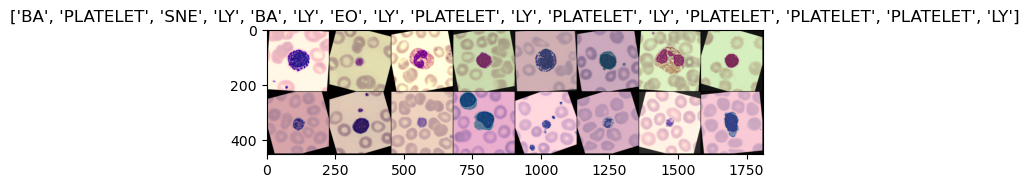

In [3]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    # mean = np.array([0.485, 0.456, 0.406])
    # std = np.array([0.229, 0.224, 0.225])
    # inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

Training the model
==================

Now, let\'s write a general function to train a model. Here, we will
illustrate:

-   Scheduling the learning rate
-   Saving the best model

In the following, parameter `scheduler` is an LR scheduler object from
`torch.optim.lr_scheduler`.


Visualizing the model predictions
=================================

Generic function to display predictions for a few images


In [4]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

Finetuning the ConvNet
======================

Load a pretrained model and reset final fully connected layer.


In [5]:
device

device(type='cuda', index=0)

In [6]:
model_ft = models.resnet34(weights='IMAGENET1K_V1')
custom_model_params_path = "./ckpts/model_wbc_resnet34.pth"
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to ``nn.Linear(num_ftrs, len(class_names))``.
model_ft.fc = nn.Linear(num_ftrs, len(class_names))

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.AdamW(model_ft.parameters(), lr=0.001)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=10, gamma=0.1)

Train and evaluate
==================

It should take around 15-25 min on CPU. On GPU though, it takes less
than a minute.


In [7]:
from tqdm import tqdm
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_val_acc = 100

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')
    
        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for inputs, labels in tqdm(dataloaders[phase]):
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                # deep copy the model
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)
                    torch.save(model.state_dict(), custom_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path))
    return model

In [8]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------


  0%|          | 0/289 [00:00<?, ?it/s]

100%|██████████| 289/289 [00:17<00:00, 16.45it/s]


train Loss: 0.3522 Acc: 0.8785


100%|██████████| 72/72 [00:01<00:00, 45.06it/s]


val Loss: 0.4323 Acc: 0.8624

Epoch 1/24
----------


100%|██████████| 289/289 [00:16<00:00, 17.22it/s]


train Loss: 0.2056 Acc: 0.9315


100%|██████████| 72/72 [00:01<00:00, 45.19it/s]


val Loss: 0.3716 Acc: 0.8475

Epoch 2/24
----------


100%|██████████| 289/289 [00:17<00:00, 16.97it/s]


train Loss: 0.1321 Acc: 0.9573


100%|██████████| 72/72 [00:01<00:00, 46.13it/s]


val Loss: 0.0665 Acc: 0.9746

Epoch 3/24
----------


100%|██████████| 289/289 [00:16<00:00, 17.19it/s]


train Loss: 0.1409 Acc: 0.9527


100%|██████████| 72/72 [00:01<00:00, 45.37it/s]


val Loss: 0.0518 Acc: 0.9842

Epoch 4/24
----------


100%|██████████| 289/289 [00:16<00:00, 17.03it/s]


train Loss: 0.0774 Acc: 0.9777


100%|██████████| 72/72 [00:01<00:00, 45.74it/s]


val Loss: 0.0983 Acc: 0.9755

Epoch 5/24
----------


100%|██████████| 289/289 [00:16<00:00, 17.04it/s]


train Loss: 0.0911 Acc: 0.9685


100%|██████████| 72/72 [00:01<00:00, 45.43it/s]


val Loss: 0.3712 Acc: 0.8843

Epoch 6/24
----------


100%|██████████| 289/289 [00:16<00:00, 17.05it/s]


train Loss: 0.1050 Acc: 0.9651


100%|██████████| 72/72 [00:01<00:00, 45.59it/s]


val Loss: 0.0228 Acc: 0.9912

Epoch 7/24
----------


100%|██████████| 289/289 [00:17<00:00, 17.00it/s]


train Loss: 0.0516 Acc: 0.9839


100%|██████████| 72/72 [00:01<00:00, 45.44it/s]


val Loss: 0.0919 Acc: 0.9632

Epoch 8/24
----------


100%|██████████| 289/289 [00:17<00:00, 16.88it/s]


train Loss: 0.0624 Acc: 0.9803


100%|██████████| 72/72 [00:01<00:00, 45.58it/s]


val Loss: 0.0237 Acc: 0.9912

Epoch 9/24
----------


100%|██████████| 289/289 [00:17<00:00, 16.84it/s]


train Loss: 0.0550 Acc: 0.9839


100%|██████████| 72/72 [00:01<00:00, 44.60it/s]


val Loss: 0.0310 Acc: 0.9869

Epoch 10/24
----------


100%|██████████| 289/289 [00:17<00:00, 16.93it/s]


train Loss: 0.0224 Acc: 0.9926


100%|██████████| 72/72 [00:01<00:00, 44.68it/s]


val Loss: 0.0116 Acc: 0.9965

Epoch 11/24
----------


100%|██████████| 289/289 [00:17<00:00, 16.67it/s]


train Loss: 0.0117 Acc: 0.9957


100%|██████████| 72/72 [00:01<00:00, 45.40it/s]


val Loss: 0.0106 Acc: 0.9965

Epoch 12/24
----------


100%|██████████| 289/289 [00:17<00:00, 16.75it/s]


train Loss: 0.0119 Acc: 0.9967


100%|██████████| 72/72 [00:01<00:00, 44.60it/s]


val Loss: 0.0089 Acc: 0.9982

Epoch 13/24
----------


100%|██████████| 289/289 [00:16<00:00, 17.02it/s]


train Loss: 0.0094 Acc: 0.9967


100%|██████████| 72/72 [00:01<00:00, 45.29it/s]


val Loss: 0.0080 Acc: 0.9974

Epoch 14/24
----------


100%|██████████| 289/289 [00:17<00:00, 16.72it/s]


train Loss: 0.0081 Acc: 0.9978


100%|██████████| 72/72 [00:01<00:00, 45.70it/s]


val Loss: 0.0085 Acc: 0.9991

Epoch 15/24
----------


100%|██████████| 289/289 [00:17<00:00, 16.92it/s]


train Loss: 0.0064 Acc: 0.9989


100%|██████████| 72/72 [00:01<00:00, 45.26it/s]


val Loss: 0.0057 Acc: 0.9982

Epoch 16/24
----------


100%|██████████| 289/289 [00:17<00:00, 16.74it/s]


train Loss: 0.0071 Acc: 0.9987


100%|██████████| 72/72 [00:01<00:00, 44.86it/s]


val Loss: 0.0087 Acc: 0.9947

Epoch 17/24
----------


100%|██████████| 289/289 [00:17<00:00, 16.66it/s]


train Loss: 0.0068 Acc: 0.9985


100%|██████████| 72/72 [00:01<00:00, 45.98it/s]


val Loss: 0.0078 Acc: 0.9965

Epoch 18/24
----------


100%|██████████| 289/289 [00:17<00:00, 16.68it/s]


train Loss: 0.0067 Acc: 0.9980


100%|██████████| 72/72 [00:01<00:00, 46.87it/s]


val Loss: 0.0053 Acc: 0.9982

Epoch 19/24
----------


100%|██████████| 289/289 [00:17<00:00, 16.61it/s]


train Loss: 0.0091 Acc: 0.9963


100%|██████████| 72/72 [00:01<00:00, 43.89it/s]


val Loss: 0.0017 Acc: 1.0000

Epoch 20/24
----------


100%|██████████| 289/289 [00:19<00:00, 14.78it/s]


train Loss: 0.0089 Acc: 0.9983


100%|██████████| 72/72 [00:01<00:00, 41.67it/s]


val Loss: 0.0021 Acc: 1.0000

Epoch 21/24
----------


100%|██████████| 289/289 [00:18<00:00, 15.27it/s]


train Loss: 0.0047 Acc: 0.9989


100%|██████████| 72/72 [00:01<00:00, 45.96it/s]


val Loss: 0.0046 Acc: 0.9982

Epoch 22/24
----------


100%|██████████| 289/289 [00:17<00:00, 16.89it/s]


train Loss: 0.0043 Acc: 0.9987


100%|██████████| 72/72 [00:01<00:00, 44.96it/s]


val Loss: 0.0048 Acc: 0.9991

Epoch 23/24
----------


100%|██████████| 289/289 [00:16<00:00, 17.03it/s]


train Loss: 0.0032 Acc: 0.9993


100%|██████████| 72/72 [00:01<00:00, 44.65it/s]


val Loss: 0.0020 Acc: 1.0000

Epoch 24/24
----------


100%|██████████| 289/289 [00:17<00:00, 16.89it/s]


train Loss: 0.0071 Acc: 0.9987


100%|██████████| 72/72 [00:01<00:00, 44.14it/s]

val Loss: 0.0030 Acc: 0.9991

Training complete in 7m 54s
Best val Acc: 1.000000


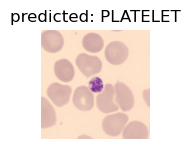

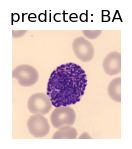

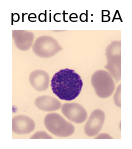

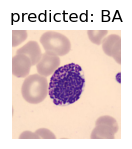

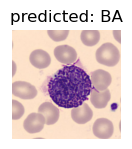

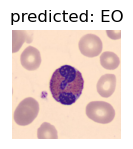

In [9]:
visualize_model(model_ft)